# Aligning Taxonomies of Disparate Datasets using Ontologies
## ODSC Webinar April 27, 2021
### Elizabeth Michel

Resources:
 * [OpenLibrary API](https://openlibrary.org/dev/docs/api/books)
 * [CWRC Ontology](http://sparql.cwrc.ca/)
 * [GoodReads Books Dataset](https://www.kaggle.com/jealousleopard/goodreadsbooks?select=books.csv)
 * [Amazon Reviews Dataset](http://snap.stanford.edu/data/web-Amazon-links.html)
 * [Pre-trained Wikipedia Doc2Vec Model](https://github.com/jhlau/doc2vec)

In [ ]:
import pandas as pd
import numpy as np
from treelib import Node, Tree
import string
from owlready2 import *
from neo4j import GraphDatabase
import itertools
from tqdm import tqdm
import re
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from textblob import TextBlob, Word
import pattern
from pattern.en import lemma, lexeme
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import smart_open
smart_open.open = smart_open.smart_open
import gensim.models as gensim
import codecs
import scipy
import matplotlib.pyplot as plt
import math
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

## Datasets

In [7]:
az = pd.read_csv("Datasets/amazon_data_extracted.csv")
gr = pd.read_csv("Datasets/goodreads_books.csv")
on = pd.read_csv("Datasets/ontology_taxonomy.csv")
defs = pd.read_csv("Datasets/ontology_definitions.csv")
a_tax = pd.read_csv("Datasets/amazon_taxonomy.csv")
o_tax = pd.read_csv("Datasets/ontology_taxonomy.csv")
g_tax = pd.read_csv("Datasets/goodreads_taxonomy.csv")

## Visualize Taxonomies

In [9]:
def build_tree(df,root_name):
    tree = Tree()
    tree.create_node(root_name,0)
    column_list = list(df.columns)
    for i, c in df.iterrows():
        node_id_list = []
        node_name_list = []
        for col in column_list:
            if type(c[col]) != float:
                node_id_list.append(c[col].replace(" ","").replace("&","").replace(",","").lower())
                node_name_list.append(c[col])
            else:
                node_id_list.append("")
                node_name_list.append("")
        if node_id_list[0] != "":
            if tree.get_node(node_id_list[0]) == None:
                tree.create_node(node_name_list[0],node_id_list[0],parent=0)
        for i in range(1,len(node_id_list)):
            if node_id_list[i] != "":
                if tree.get_node(node_id_list[i]) == None:
                    tree.create_node(node_name_list[i],node_id_list[i],parent=node_id_list[i-1])
    return tree

#### Build and visualize Amazon taxonomy tree

In [10]:
tree_az = build_tree(az[['tier_1','tier_2','tier_3','tier_4','tier_5','tier_6']].drop_duplicates(),"amazon")
#tree_az.show()

#### Build and visualize GoodReads taxonomy tree

In [11]:
tree_gr = build_tree(gr.drop(columns=['title']).drop_duplicates(),"goodreads")
#tree_gr.show()

#### Build and visualize CWRC Ontology taxonomy tree of genres

In [12]:
tree_on = build_tree(on,"ontology")
#tree_on.show()

##  Amazon / Ontology Answer Key
#### { Amazon Genre tier_1 } = Ontology Genre

In [13]:
az_key_dict = {}

az_key_dict['Education & Reference'] = "DidacticGenre"
az_key_dict['Self-Help'] = "DidacticGenre"
az_key_dict['History'] = "HistoricalGenre"
az_key_dict['Travel'] = "ReferenceWorkGenre"
az_key_dict['Crafts'] = "ReferenceWorkGenre"
az_key_dict['Medical Books'] = "ReferenceWorkGenre"
az_key_dict['Cookbooks'] = "ReferenceWorkGenre"
az_key_dict['Arts & Photography'] = "ReferenceWorkGenre"
az_key_dict['Parenting & Relationships'] = "ReferenceWorkGenre"
az_key_dict['Health'] = "ReferenceWorkGenre"
az_key_dict['Business & Investing'] = "PedagogicalGenre"
az_key_dict['Professional & Technical'] = "PedagogicalGenre"
az_key_dict['Science & Math'] = "PedagogicalGenre"
az_key_dict['Computers & Technology'] = "PedagogicalGenre"
az_key_dict['Law'] = "PedagogicalGenre"
az_key_dict['Politics & Social Sciences'] = "SocialScienceGenre"
az_key_dict["Children's Books"] = "ChildrensLiteratureGenre"
az_key_dict['Teens'] = "ChildrensLiteratureGenre"
az_key_dict['Humor & Entertainment'] = "ComedicGenre"
az_key_dict['Science Fiction & Fantasy'] = "FictionalGenre"
az_key_dict['Literature & Fiction'] = "NovelisticGenre"
az_key_dict['Biographies & Memoirs'] = "LifeWritingGenre"
az_key_dict['Christian Books & Bibles'] = "ReligiousGenre"
az_key_dict['Religion & Spirituality'] = "ReligiousGenre"
az_key_dict['Romance'] = "RomanceGenre"
az_key_dict['Gay & Lesbian'] = "LGBTQPlusGenre"
az_key_dict['Mystery'] = "MysteryGenre"
az_key_dict['Calendars'] = "InformationalGenre"

#### Answer Key as Tuples

In [14]:
az_key_tuples = [("Education & Reference","ReferenceWorkGenre"),
                ("Self-Help","DidacticGenre"),
                ("History","HistoricalGenre"),
                ("Travel","ReferenceWorkGenre"),
                ("Crafts","ReferenceWorkGenre"),
                ("Medical Books","ScholarlyGenre"),
                ("Cookbooks","ReferenceWorkGenre"),
                ("Arts & Photography","ReferenceWorkGenre"),
                ("Parenting & Relationships","ReferenceWorkGenre"),
                ("Health","ReferenceWorkGenre"),
                ("Business & Investing","PedagogicalGenre"),
                ("Professional & Technical","PedagogicalGenre"),
                ("Science & Math","PedagogicalGenre"),
                ("Computers & Technology","PedagogicalGenre"),
                ("Law","PoliticalGenre"),
                ("Politics & Social Sciences","SocialScienceGenre"),
                ("Children's Books","ChildrensLiteratureGenre"),
                ("Teens","ChildrensLiteratureGenre"),
                ("Humor & Entertainment","ComedicGenre"),
                ("Science Fiction & Fantasy","FictionalGenre"),
                ("Literature & Fiction","LiteraryGenre"),
                ("Biographies & Memoirs","LifeWritingGenre"),
                ("Christian Books & Bibles","ReligiousGenre"),
                ("Romance","RomanceGenre"),
                ("Gay & Lesbian","LGBTQPlusGenre"),
                ("Mystery","MysteryGenre"),
                ("Calendars","InformationalGenre"),
                ('Religion & Spirituality', 'ReligiousGenre'),
                ('Comics & Graphic Novels', 'LiteraryGenre')]

## Taxonomy Alignment Prediction

### Synonyms

In [15]:
def wordnet_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lm in syn.lemmas():
            synonyms.append(lm.name())
    syn_dedup = []
    [syn_dedup.append(x) for x in synonyms if x not in syn_dedup]
    return syn_dedup

# amazon vs. ontology
def list_categories(df):
    cats = []
    for i in range(0,len(df)):
        for column in list(df.columns):
            if (not df.loc[i,column] in cats) and (type(df.loc[i,column])==str):
                cats.append(df.loc[i,column])
    return cats

# lemmatizer = WordNetLemmatizer()

# def list_lemmatizer(list_to_lemmatize):
#     return [lemmatizer.lemmatize(wd,"n") for wd in list_to_lemmatize]

# def word_lemmatizer(word):
#     return lemmatizer.lemmatize(word,"n")

#### Extract words from titles

In [16]:
# dictionary of all category titles ('PoliticalGenre') to a list of their words (['Political'])
word_dict = {}

# ontology words
for i in range(0,len(o_tax)):
    for column in list(o_tax.columns):
        if type(o_tax.loc[i,column])==str:
            genre = o_tax.loc[i,column].replace("Genre","")
            word_dict[o_tax.loc[i,column]] = [ wd.lower() for wd in re.findall('[A-Z][^A-Z]*',genre) ]

# amazon words
for i in range(0,len(a_tax)):
    genre_words = a_tax.loc[i,'tier_1'].replace("& ","").replace("  "," ").rstrip().lstrip().split(" ")
    word_dict[a_tax.loc[i,'tier_1']] = genre_words

for i in range(0,len(g_tax)):

    if type(g_tax.loc[i,"tier_1"])==str:
        genre = g_tax.loc[i,"tier_1"]
        genre_words = [re.sub(r'[^\w\s]', '', word) for word in genre.split(" ")]
        word_dict[g_tax.loc[i,"tier_1"]] = [ wd.lower() for wd in genre_words ]

print("Example\n  word_dict['ReferenceWorkGenre']: "+str(word_dict['ReferenceWorkGenre']))

Example
  word_dict['ReferenceWorkGenre']: ['reference', 'work']


In [17]:
g_tax.loc[:,'tier_1'] = g_tax.loc[:,'tier_1'].apply(lambda x: "" if isinstance(x, np.float64) else x)

In [18]:
word_dict['LGBTQPlusGenre'] = ['lesbian', 'gay', 'bisexual', 'transexual', 'queer', 'plus']

#### List Categories

In [19]:
syn_sym_scores = {}
o_cats = list_categories(o_tax)
#g_cats = list_categories(g_tax)
g_cats = list(g_tax.tier_1.unique())
a_cats = [word.lstrip().rstrip() for word in list(a_tax.tier_1.unique())]
print("o_cats: "+str(o_cats[:5]))
print("g_cats: "+str(g_cats[:5]))
print("a_cats: "+str(a_cats[:5]))

o_cats: ['PoliticalGenre', 'MusicalGenre', 'InformationalGenre', 'ThematicGenre', 'IntertextualGenre']
g_cats: ['orphans', "Children's Books/Ages 9-12 Fiction", 'Fantasy fiction', 'fantasy fiction', 'Potter, harry (fictitious character), fiction']
a_cats: ['Literature & Fiction', 'Science Fiction & Fantasy', 'Business & Investing', 'Biographies & Memoirs', 'Health']


#### Build dataframes to hold scores

Amazon

In [20]:
ontology_vs_amazon = pd.DataFrame(columns=['ontology_genre','amazon_genre'])
for ocat in o_cats:
    for acat in a_cats:
        if (type(ocat)==str) and (type(acat)==str):
            df_temp = pd.DataFrame(data=[[ocat,acat]],columns=['ontology_genre','amazon_genre'])
            ontology_vs_amazon = ontology_vs_amazon.append(df_temp)
ontology_vs_amazon = ontology_vs_amazon.reset_index().drop(columns=['index'])

GoodReads

In [21]:
ontology_vs_goodreads = pd.DataFrame(columns=['ontology_genre','goodreads_genre'])
for ocat in o_cats:
    for gcat in g_cats:
        df_temp = pd.DataFrame(data=[[ocat,gcat]],columns=['ontology_genre','goodreads_genre'])
        ontology_vs_goodreads = ontology_vs_goodreads.append(df_temp)
ontology_vs_goodreads = ontology_vs_goodreads.reset_index().drop(columns=['index'])

In [22]:
ontology_vs_goodreads.loc[:,'goodreads_genre'] = ontology_vs_goodreads.loc[:,'goodreads_genre'].apply(lambda x: "" 
                                                                                        if type(x)==float else x)

In [23]:
ontology_vs_goodreads = ontology_vs_goodreads[ontology_vs_goodreads['goodreads_genre']!=""]
ontology_vs_goodreads = ontology_vs_goodreads.reset_index().drop(columns=['index'])

### Synonym Similarity Scoring

In [25]:
def score_similarity(o_genre,book_genre):
    o_synonyms = []
    for wd in word_dict[o_genre]:
        o_synonyms.append(wd)
        o_synonyms.extend(wordnet_synonyms(wd))
    a_g_synonyms = []
    for wd in word_dict[book_genre]:
        a_g_synonyms.append(wd)
        a_g_synonyms.extend(wordnet_synonyms(wd))
    score = len(set(o_synonyms) & set(a_g_synonyms)) / (len(o_synonyms)+len(a_g_synonyms))
    return score

# amazon
ontology_vs_amazon['synonym_similarity'] = ontology_vs_amazon.apply(lambda x: 
                                                     score_similarity(x.ontology_genre, x.amazon_genre), axis=1)
# goodreads
ontology_vs_goodreads['synonym_similarity'] = ontology_vs_goodreads.apply(lambda x: 
                                                     score_similarity(x.ontology_genre, x.goodreads_genre), axis=1)

KeyboardInterrupt: 

In [26]:
wordnet_synonyms("Tales")

['narrative', 'narration', 'story', 'tale', 'fib', 'tarradiddle', 'taradiddle']

In [27]:
wordnet_synonyms("Narrative")

['narrative', 'narration', 'story', 'tale']

In [28]:
a = len(set(wordnet_synonyms("Tales")) & set(wordnet_synonyms("Narrative")))
b = len(wordnet_synonyms("Tales")) + len(wordnet_synonyms("Narrative"))
print(str(round(a / b * 100, 2))+"%")

36.36%


In [29]:
def get_score(ont_genre,gr_genre):
    if type(gr_genre)==str:
        return syn_sym_scores[ont_genre,gr_genre]+model_defs_subcats.docvecs.similarity(gr_genre,ont_genre)
    else:
        return 0
    
def get_match(genre):
    score = 0
    match = ""
    for cat in o_cats:
        if (get_score(cat,genre)>score):
            score = get_score(cat,genre)
            match = cat
    return score, match

# Doc2Vec Model Pre-Trained on Wikipedia Articles

Load model and set alpha and epoch values

In [30]:
# load model
model="Model/enwiki_dbow/doc2vec.bin"
import gensim.models as g
m = g.Doc2Vec.load(model)

# inference hyper-parameters
start_alpha=0.01
infer_epoch=1000

Test how it works with two lists of words that should be similar

In [31]:
o = ['biographies','memoirs']
a = ['life','writing','genre']
o_vec = m.infer_vector(o, alpha=start_alpha, steps=infer_epoch)
a_vec = m.infer_vector(a, alpha=start_alpha, steps=infer_epoch)
cosine_similarity = 1 - scipy.spatial.distance.cosine(o_vec, a_vec)
print(str(round(cosine_similarity*100,2))+"% similar")

62.34% similar


In [32]:
m.docvecs.similarity_unseen_docs(m, o, a)

0.6825348

Dictionary of words in Amazon genre and sub-genres combined

In [33]:
amazon_word_dict = {}
for i in range(0,len(a_tax)):
    amazon_word_dict[a_tax.loc[i,'tier_1']] = [x.lower() for x in 
                                                    a_tax.loc[i,'all_cats'].split(" ") if x]

Dictionary of words in ontology definitions

In [34]:
genre_def_dict = {}
regex = re.compile('[%s]' % re.escape(string.punctuation))

for i in range(0,len(defs)):
    genre = defs.loc[i,'key'].replace(" ","")+"Genre"
    definition = regex.sub('',defs.loc[i,'definition'])
    genre_def_dict[genre] = [x.lower() for x in definition.split(" ")]

Scoring functions

In [35]:
def score_doc2vec(o_words,a_g_words):
    o_vector = m.infer_vector(o_words, alpha = start_alpha, steps = infer_epoch)
    a_g_vector = m.infer_vector(a_g_words, alpha = start_alpha, steps = infer_epoch)
    cosine_similarity = 1 - scipy.spatial.distance.cosine(o_vector, a_g_vector)
    return cosine_similarity

def score_doc2vec_v_unseen_docs(o_words,a_g_words):
    cosine_similarity = m.docvecs.similarity_unseen_docs(m,o_words, a_g_words)
    return cosine_similarity

def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

#### Amazon
Score based on names in genre titles only

In [43]:
ontology_vs_amazon['doc2vec_names_similarity_v_unseen_docs'] = ontology_vs_amazon.apply(lambda x: 
                                                     score_doc2vec_v_unseen_docs(word_dict[x.ontology_genre], 
                                                                   word_dict[x.amazon_genre]), axis=1)

Score based on ontology genre titles and amazon genres + subgenres

In [25]:
ontology_vs_amazon['doc2vec_subcats_similarity'] = ontology_vs_amazon.apply(lambda x: 
                                                     score_doc2vec(word_dict[x.ontology_genre], 
                                                                   amazon_word_dict[x.amazon_genre]), axis=1)

Score based on ontology genre definitions and amazon genres + subgenres

In [26]:
ontology_vs_amazon['doc2vec_subcats_defs_similarity'] = ontology_vs_amazon.apply(lambda x: 
                                                     score_doc2vec(genre_def_dict[x.ontology_genre], 
                                                                   amazon_word_dict[x.amazon_genre]), axis=1)

#### Goodreads
Score based on names in genre titles only

In [27]:
ontology_vs_goodreads['doc2vec_names_similarity'] = ontology_vs_goodreads.apply(lambda x: 
                                                     score_doc2vec(word_dict[x.ontology_genre], 
                                                                   word_dict[x.goodreads_genre]), axis=1)

Score based on ontology genre definitions and goodreads genre titles

In [28]:
tqdm.pandas()
ontology_vs_goodreads['doc2vec_names_defs_similarity'] = ontology_vs_goodreads.progress_apply(lambda x: 
                                                     score_doc2vec(genre_def_dict[x.ontology_genre], 
                                                                   word_dict[x.goodreads_genre]), axis=1)

In [29]:
tqdm.pandas()
ontology_vs_goodreads['doc2vec_names_defs_similarity'] = ontology_vs_goodreads.progress_apply(lambda x: 
                                                     score_doc2vec(genre_def_dict[x.ontology_genre], 
                                                                   word_dict[x.goodreads_genre]), axis=1)

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 102696/102696 [17:13:52<00:00,  1.66it/s]       


Goodreads answer key

In [36]:
g_ak = pd.read_csv("Datasets/goodreads_answer_key.csv")

Denote pairs verified in answer key

In [37]:
def amazon_is_verified(amazon_genre, ontology_genre):
    if (amazon_genre, ontology_genre) in az_key_tuples:
        return 1 # correct
    elif amazon_genre in az_key_dict: # if it's not a match but the match exists for that amazon genre
        return -1 # incorrect
    else:
        return 0 # unspecified

def goodreads_is_verified(gr_genre, o_genre):
    if gr_genre in list(g_ak.goodreads_genre):
        if g_ak.loc[g_ak['goodreads_genre'] == gr_genre, 'ontology_genre'].iloc[0] == o_genre:
            return 1
        else:
            return -1
    else:
        return 0

ontology_vs_amazon.loc[:,'verified'] = ontology_vs_amazon.apply(lambda x: 
                                                    amazon_is_verified(x.amazon_genre, x.ontology_genre), axis=1)

ontology_vs_goodreads.loc[:,'verified'] = ontology_vs_goodreads.apply(lambda x: 
                                                    goodreads_is_verified(x.goodreads_genre, x.ontology_genre), 
                                                                      axis=1)

## Amazon Scoring Model

If doc2vec_names_similarity <= 0.2, score = doc2vec_subcats_similarity

In [178]:
def score_1(names,subcats):
    if names<=0.2:
        return subcats
    else:
        return 0

ontology_vs_amazon.loc[:,'score_1'] = ontology_vs_amazon.apply(lambda x: 
                                            score_1(x.doc2vec_names_similarity, x.doc2vec_subcats_similarity), axis=1)

If doc2vec_names_similarity > 0.2, score = distance from best fit line of matches

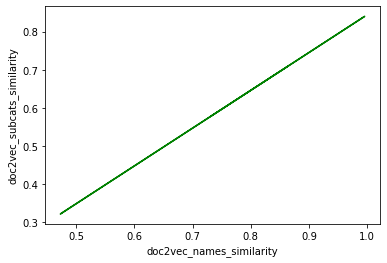

In [179]:
verified = ontology_vs_amazon[ontology_vs_amazon.verified==1]
above_threshold_verified = verified[verified.doc2vec_names_similarity>0.2]
x_above_threshold = np.array(list(above_threshold_verified.doc2vec_names_similarity))
y_above_threshold = np.array(list(above_threshold_verified.doc2vec_subcats_similarity))
m, b = np.polyfit(x_above_threshold, y_above_threshold, 1)
plt.plot(x_above_threshold, m*x_above_threshold + b,'g')
plt.xlabel("doc2vec_names_similarity")
plt.ylabel("doc2vec_subcats_similarity")
plt.show()

In [180]:
A = m
B = -2
C = b

# Function to find distance
def shortest_distance(x1, y1, A, B, C):
    d = abs((A * x1 + B * y1 + C)) / (math.sqrt(A * A + B * B))
    return d

def score_2(names,subcats):
    if names>0.2:
        return shortest_distance(names,subcats,A,B,C)
    else:
        return 0

ontology_vs_amazon.loc[:,'score_2'] = ontology_vs_amazon.apply(lambda x: 
                                    score_2(x.doc2vec_names_similarity, x.doc2vec_subcats_similarity), axis=1)

In [181]:
score_1_mean = ontology_vs_amazon.score_1.mean()
score_2_mean = ontology_vs_amazon.score_2.mean()
scale_multiplier = score_1_mean / score_2_mean

In [182]:
ontology_vs_amazon.loc[:,'scaled_score_2'] = ontology_vs_amazon.loc[:,'score_2'].apply(lambda x: scale_multiplier*x)

In [183]:
ontology_vs_amazon.loc[:,'score'] = ontology_vs_amazon.loc[:,'score_1'] + ontology_vs_amazon.loc[:,'scaled_score_2']

In [184]:
idx = ontology_vs_amazon.groupby(['amazon_genre'])['score'].transform(max) == ontology_vs_amazon['score']
amazon_matches = ontology_vs_amazon[idx]
amazon_matches.head(5)

,ontology_genre,amazon_genre,synonym_similarity,doc2vec_names_similarity,doc2vec_subcats_similarity,doc2vec_subcats_defs_similarity,verified,doc2vec_names_similarity_v_unseen_docs,score_1,score_2,scaled_score_2,score
40,MusicalGenre,Arts & Photography,0.0,0.001146,0.686881,0.494828,-1,-0.089871,0.686881,0.000000,0.000000,0.686881
89,InformationalGenre,Sports & Outdoors,0.0,-0.000767,0.542015,0.332635,0,0.093676,0.542015,0.000000,0.000000,0.542015
119,ThematicGenre,Cookbooks,0.0,0.544389,0.428679,0.340168,-1,0.553478,0.000000,0.208195,1.296025,1.296025
163,ReligiousGenre,Teens,0.0,0.088062,0.680727,0.378412,-1,-0.120742,0.680727,0.000000,0.000000,0.680727
167,ReligiousGenre,Christian Books & Bibles,0.0,0.030673,0.619892,0.376549,1,0.028918,0.619892,0.000000,0.000000,0.619892


## GoodReads Scoring Model

Score = doc2vec_names_similarity + doc2vec_names_defs_similarity + synonym_similarity

In [146]:
ontology_vs_goodreads.loc[:,'score'] = ontology_vs_goodreads.loc[:,'synonym_similarity']+ontology_vs_goodreads.loc[:,'doc2vec_names_similarity']+ontology_vs_goodreads.loc[:,'doc2vec_names_defs_similarity']

Get IDs fo the maximum scored ontology_genre per goodreads_genre

In [147]:
idx = ontology_vs_goodreads.groupby(['goodreads_genre'])['score'].transform(max) == ontology_vs_goodreads['score']

Filter dataframe to "matches" and add a match/no-match field to the original dataframe

In [148]:
goodreads_matches = ontology_vs_goodreads[idx][['goodreads_genre','ontology_genre','score','verified']]
goodreads_matches.loc[:,'key'] = goodreads_matches.loc[:,'goodreads_genre']+"|"+goodreads_matches.loc[:,'ontology_genre']
goodreads_match_keys = list(goodreads_matches.key)
ontology_vs_goodreads.loc[:,'key'] = ontology_vs_goodreads.loc[:,'goodreads_genre']+"|"+ontology_vs_goodreads.loc[:,'ontology_genre']
ontology_vs_goodreads.loc[:,'match'] = ontology_vs_goodreads.loc[:,'key'].apply(lambda x: 
                                                                    1 if x in goodreads_match_keys else 0)
ontology_vs_goodreads[ontology_vs_goodreads.match==1].head(5)

,ontology_genre,goodreads_genre,synonym_similarity,doc2vec_names_similarity,doc2vec_names_defs_similarity,verified,score,key,match
110,PoliticalGenre,Election,0.000000,0.704796,0.246495,1,0.951291,Election|PoliticalGenre,1
185,PoliticalGenre,politics,0.000000,0.890885,0.347064,0,1.237949,politics|PoliticalGenre,1
204,PoliticalGenre,Views on political leadership,0.027027,0.823849,0.305967,0,1.156843,Views on political leadership|PoliticalGenre,1
263,PoliticalGenre,"United states, politics and government",0.000000,0.773560,0.369636,0,1.143196,"United states, politics and government|Politic...",1
344,PoliticalGenre,Union Army,0.000000,0.610811,0.302632,0,0.913443,Union Army|PoliticalGenre,1


## Model Analysis and Metric Plotting

In [40]:
ontology_vs_amazon = pd.read_csv("ontology_vs_amazon.csv")
ontology_vs_goodreads = pd.read_csv("ontology_vs_goodreads.csv")

In [41]:
def generate_graph_dependencies(dataset, genre, metric_x, metric_y):
    if 'amazon_genre' in dataset.columns:
        subset = dataset[dataset.amazon_genre==genre]
        print('amazon: '+str(len(subset)))
    elif 'goodreads_genre' in dataset.columns:
        subset = dataset[dataset.goodreads_genre==genre]
        print('goodreads: '+str(len(subset)))
    subset_0 = subset[subset.verified==-1]
    print('unverified: '+str(len(subset_0)))
    subset_1 = subset[subset.verified==1]
    print('verified: '+str(len(subset_1)))
    x_0 = np.array(list(subset_0[metric_x]))
    y_0 = np.array(list(subset_0[metric_y]))
    x_1 = np.array(list(subset_1[metric_x]))
    y_1 = np.array(list(subset_1[metric_y]))
    return x_0,y_0,x_1,y_1

def generate_graph(x_0,y_0,x_1,y_1,genre,dataset,metric_x,metric_y):
    plt.scatter(x_0,y_0,color='lightsteelblue')
    plt.scatter(x_1,y_1,color='b')

    plt.xlabel(metric_x)
    plt.ylabel(metric_y)
    plt.title(genre)
    xmin = dataset[metric_x].min()
    xmax = dataset[metric_x].max()
    ymin = dataset[metric_y].min()
    ymax = dataset[metric_y].max()
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.show()

### Visualizing genres
#### Amazon 
Genre list

In [45]:
ontology_vs_amazon.amazon_genre.unique()

array(['Literature & Fiction', 'Science Fiction & Fantasy',
       'Business & Investing', 'Biographies & Memoirs', 'Health',
       'Humor & Entertainment', 'Self-Help', "Children's Books", 'Teens',
       'Arts & Photography', 'Education & Reference',
       'Politics & Social Sciences', 'Christian Books & Bibles',
       'Religion & Spirituality', 'New', 'Romance', 'History',
       'Professional & Technical', 'Science & Math',
       'Computers & Technology', 'Parenting & Relationships', 'Travel',
       'Crafts', 'Gay & Lesbian', 'Medical Books', 'Mystery', 'Cookbooks',
       'Sports & Outdoors', 'Law', 'Comics & Graphic Novels', 'Calendars'],
      dtype=object)

Amazon metrics

In [58]:
list(ontology_vs_amazon.columns[2:len(list(ontology_vs_amazon.columns))-1])

['synonym_similarity',
 'doc2vec_names_similarity',
 'doc2vec_subcats_similarity',
 'doc2vec_subcats_defs_similarity']

Example amazon genre visualization

amazon: 33
unverified: 32
verified: 1


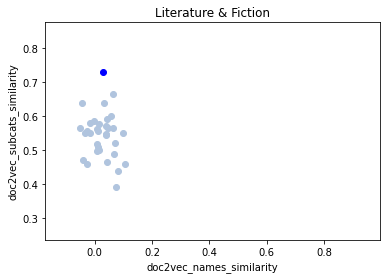

In [52]:
genre = "Literature & Fiction"
x_0,y_0,x_1,y_1 = generate_graph_dependencies(ontology_vs_amazon,genre,"doc2vec_names_similarity",'doc2vec_subcats_similarity')
generate_graph(x_0,y_0,x_1,y_1,genre,ontology_vs_amazon,"doc2vec_names_similarity","doc2vec_subcats_similarity")


#### Goodreads
Genre List

In [53]:
ontology_vs_goodreads.goodreads_genre.unique()

array(['orphans', "Children's Books/Ages 9-12 Fiction", 'Fantasy fiction',
       ..., 'Confederate States of America', 'Juvenile drama',
       'Ajax (Web site development technology)'], dtype=object)

Goodreads metrics

In [59]:
list(ontology_vs_goodreads.columns[2:len(list(ontology_vs_goodreads.columns))-1])

['synonym_similarity',
 'doc2vec_names_similarity',
 'doc2vec_names_defs_similarity']

goodreads: 33
unverified: 32
verified: 1


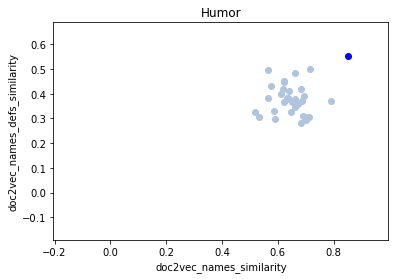

In [43]:
genre = "Humor"
x_0,y_0,x_1,y_1 = generate_graph_dependencies(ontology_vs_goodreads,genre,"doc2vec_names_similarity","doc2vec_names_defs_similarity")
generate_graph(x_0,y_0,x_1,y_1,genre,ontology_vs_goodreads,"doc2vec_names_similarity","doc2vec_names_defs_similarity")


## Join in Books
#### Goodreads

In [149]:
gr_match_dict = dict(zip(goodreads_matches.goodreads_genre, goodreads_matches.ontology_genre))
gr.loc[:,'ontology_genre'] = gr.loc[:,'genre1'].apply(lambda x: gr_match_dict[x] if x in gr_match_dict else "")
gr.head(5)

,title,genre1,genre2,ontology_genre
0,Harry Potter and the Half-Blood Prince (Harry ...,orphans,foster homes,PedagogicalGenre
1,Harry Potter and the Order of the Phoenix (Har...,Children's Books/Ages 9-12 Fiction,Witches and warlocks,ChildrensLiteratureGenre
2,Harry Potter and the Chamber of Secrets (Harry...,Fantasy fiction,school stories,MysteryGenre
3,Harry Potter and the Prisoner of Azkaban (Harr...,fantasy fiction,orphans,MysteryGenre
4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"Potter, harry (fictitious character), fiction",Hogwarts school of witchcraft and wizardry (im...,FictionalGenre


In [169]:
gr = gr.reset_index().drop(columns=['index'])

#### Amazon

In [187]:
az_match_dict = dict(zip(amazon_matches.amazon_genre, amazon_matches.ontology_genre))
az.loc[:,'tier_2'] = az.loc[:,'tier_2'].apply(lambda x: x.lstrip().rstrip() if type(x)==str else "")
az.loc[:,'ontology_genre'] = az.loc[:,'tier_2'].apply(lambda x: az_match_dict[x] if x in az_match_dict else "")
az.head(5)

,title,tier_1,tier_2,tier_3,tier_4,tier_5,tier_6,ontology_genre
0,Past Imperfect (Daw Book Collectors),Books,Literature & Fiction,Anthologies & Literary Collections,General,NaN,NaN,LiteraryGenre
1,Past Imperfect (Daw Book Collectors),Books,Literature & Fiction,United States,NaN,NaN,NaN,LiteraryGenre
2,Past Imperfect (Daw Book Collectors),Books,Science Fiction & Fantasy,Science Fiction,Anthologies,NaN,NaN,SocialScienceGenre
3,Past Imperfect (Daw Book Collectors),Books,Science Fiction & Fantasy,Science Fiction,Short Stories,NaN,NaN,SocialScienceGenre
4,Winning Every Time: How to Use the Skills of a...,Books,Business & Investing,Business Life,Motivation & Self-Improvement,NaN,NaN,HistoricalGenre


# Export to Neo4j

set neo4j_dir to "data" directory of Neo4j desktop, i.e. location for csv load

In [334]:
neo4j_dir = ""

In [335]:
gr.to_csv(neo4j_dir+"goodreads_categorized_books.csv",index=False)
az.to_csv(neo4j_dir+"amazon_categorized_books.csv",index=False)

# Exploring Discrepancies

In [371]:
gr[gr['ontology_genre']=="FeministGenre"].genre1.value_counts()

Women                         12
Married women                 10
Young women                    7
Single women                   6
Divorced women                 6
                              ..
Sex role                       1
Civil disobedience             1
Mexican Americans              1
Spain Civil War, 1936-1939     1
Constitutional law             1
Name: genre1, Length: 136, dtype: int64

In [380]:
idx = ontology_vs_goodreads.groupby(['goodreads_genre'])['doc2vec_names_similarity'].transform(max)==ontology_vs_goodreads['doc2vec_names_similarity']
names_defs_matches = ontology_vs_goodreads[idx]
names_defs_matches[names_defs_matches['ontology_genre']=="FeministGenre"].goodreads_genre.value_counts()


Trials, litigation                      1
Hispanic Americans                      1
Barbecue sauce                          1
African American household employees    1
dementia                                1
                                       ..
Women inventors                         1
Aging                                   1
Racially mixed children                 1
Young Adult                             1
female subjects                         1
Name: goodreads_genre, Length: 572, dtype: int64

In [382]:
gr[gr.ontology_genre=="FeministGenre"].genre1.value_counts()

Women                         12
Married women                 10
Young women                    7
Single women                   6
Divorced women                 6
                              ..
Sex role                       1
Civil disobedience             1
Mexican Americans              1
Spain Civil War, 1936-1939     1
Constitutional law             1
Name: genre1, Length: 136, dtype: int64